# Report
### Learning Algorithm
We utilized A2C algorithm to solve this environment. 

There are two branches in the model :
    - The Actor branch outputs the probabilities mean of each action. We then create a Normal distribution to Sample the action
    - The Critic branch ouputs the value for each eaction

Both branchses shares the same base model. Both branches has one fully connected layer.

Detailed specifications is shown below, ReLU layer is embeded in the forward pass after each layer.

In [8]:
class A2C_model(nn.Module):
    def __init__(self, params_dir, input_dim , act_size):
        super().__init__()
        self.params = parse_params(params_dir)
        self.fc1 = nn.Linear(input_dim , self.params['hidden_dim'])
        self.actor_fc = nn.Linear(self.params['hidden_dim'],
                                  self.params['hidden_dim'])
        self.actor_out = nn.Linear(self.params['hidden_dim'], act_size)
        self.std = nn.Parameter(torch.ones(1, act_size))
        self.critic_fc = nn.Linear(self.params['hidden_dim'],
                                   self.params['hidden_dim'])
        self.critic_out = nn.Linear(self.params['hidden_dim'], 1)
        
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        mean = self.actor_out(F.relu(self.actor_fc(x)))
        dist = torch.distributions.Normal(mean, self.std)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic_out(F.relu(self.critic_fc(x)))
        return torch.clamp(action, -1, 1), log_prob, value

    
params_dir = f"./params.txt"
model = A2C_model(device, num_agents=4, params_dir=params_dir,
                  state_size=33, action_size=4)
print(model)

A2C_model(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (actor_fc): Linear(in_features=128, out_features=128, bias=True)
  (actor_out): Linear(in_features=128, out_features=4, bias=True)
  (critic_fc): Linear(in_features=128, out_features=128, bias=True)
  (critic_out): Linear(in_features=128, out_features=1, bias=True)
)


### Hyperparameters

All hyperparameters are saved in params.txt, here are the list of hyperparameters chosen for my implementation:

- hidden_dim": 128
    - Input and output dimension of the hidden layers
- gamma": 0.95
    - Discount factor for the future rewards
- lr": 0.0001
    - Learning rate for the optmizer to update our model
- grad_clip": 4\5
    - Maximum gradient value


### Plot of Rewards

In [8]:
import matplotlib.pyplot as plt

def plot_scores(scores):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

scores_window = deque(maxlen=100)
for i in range(500):
    env_info = env.reset(train_mode=True)[brain_name]
    states_ = env_info.vector_observations
    scores = np.zeros(num_agents)
    memories = Experience()
    done = [False] * num_agents
    steps = 0
    # while not np.any(done):
    while True:
        actions_, log_prob_, state_values_ = agent(
                torch.FloatTensor(states).to(device))
        env_info = env.step(actions_.detach().cpu().numpy())[brain_name]
        next_states_ = env_info.vector_observations
        rewards_ = env_info.rewards
        done = env_info.local_done
        not_done_ = (1 - np.array(done))
        memories.add(actions_, rewards_, log_prob_, not_done_, state_values_)
        steps += 1
        if steps % 5 == 0:
            experiences = memories.spit()
            agent.step(experiences)
            memories = Experience()
        states = next_states_
        scores += rewards_
        if np.any(done):
            break
        # print(scores)
    print(f"Episode {i}: {np.mean(scores)}")
    scores_window.append(np.mean(scores))
    if (len(scores_window)) == 100 and ((sum(scores_window) / len(scores_window)) > 30):
        torch.save(agent.model.state_dict(), agent.params['working_dir'])
        print(f"Envinroment solved in episode{i}!")
        print(f"Score: {scores_window}")
        break

Episode 0: 0.3569999920204282
Episode 1: 0.28199999369680884
Episode 2: 0.9589999785646797
Episode 3: 1.126499974820763
Episode 4: 0.6214999861083925
Episode 5: 0.06549999853596092
Episode 6: 0.3579999919980764
Episode 7: 0.3609999919310212
Episode 8: 0.36999999172985554
Episode 9: 0.3574999920092523
Episode 10: 0.4224999905563891
Episode 11: 0.6109999863430857
Episode 12: 0.6289999859407545
Episode 13: 1.0139999773353339
Episode 14: 0.8159999817609787
Episode 15: 1.0304999769665302
Episode 16: 0.9679999783635139
Episode 17: 1.246999972127378
Episode 18: 1.2299999725073576
Episode 19: 1.0244999771006404
Episode 20: 1.2444999721832573
Episode 21: 1.126999974809587
Episode 22: 1.018499977234751
Episode 23: 1.7789999602362514
Episode 24: 1.238999972306192
Episode 25: 1.6829999623820187
Episode 26: 1.567999964952469
Episode 27: 1.5589999651536346
Episode 28: 1.9289999568834901
Episode 29: 1.6939999621361495
Episode 30: 1.8774999580346048
Episode 31: 1.7549999607726932
Episode 32: 2.0839999

Score: deque([16.473499631788581, 16.888999622501434, 16.285999635979532, 17.444499610085039, 17.672999604977669, 18.490999586693942, 20.425999543443321, 21.088499528635293, 22.39599949941039, 22.204999503679574, 21.697499515023082, 24.57049945080653, 25.383999432623387, 27.208999391831458, 25.363499433081596, 26.665999403968453, 31.439499297272413, 34.193999235704538, 35.872499198187143, 37.180499168951066, 36.90599917508662, 35.062999216280879, 37.46799916252494, 37.493499161954972, 34.603499226551506, 29.486999340914188, 30.742999312840404, 36.07549919364974, 38.296999143995343, 38.116999148018657, 37.725499156769366, 38.236499145347622, 38.514999139122665, 38.503499139379713, 38.813999132439491, 38.335499143134804, 38.275999144464734, 38.480999139882627, 38.14349914742634, 38.474499140027909, 38.258999144844708, 38.643999136239287, 38.86299913134426, 38.627499136608094, 38.948499129433188, 38.78549913307652, 39.115499125700445, 38.925999129936102, 38.580499137658627, 38.28599914424

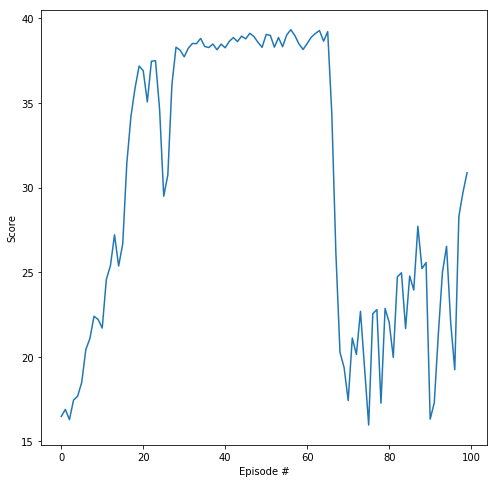

In [9]:
# plot the scores
plot_scores(scores_window)

### Ideas for Future Work
    1.Implement GAE into our network
    2.Add Entropy loss into our loss function to allow more exploration in our model
    3.Will try to add BatchNorm1d layer Leaky ReLU layer to replace to ReLU layer to see if gets better performance